In [2]:
import numpy as np
import cv2 as cv
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time
import torch
from pathlib import Path

from lac.perception.segmentation import UnetSegmentation
from lac.perception.depth import (
    stereo_depth_from_segmentation,
    project_pixel_to_rover,
    compute_rock_coords_rover_frame,
    compute_rock_radii,
)
from lac.control.controller import ArcPlanner
from lac.utils.visualization import overlay_mask, overlay_stereo_rock_depths
from lac.utils.plotting import (
    plot_points_rover_frame,
    plot_path_rover_frame,
    plot_rocks_rover_frame,
)
from lac.utils.frames import invert_transform_mat
from lac.util import load_data, get_positions_from_poses
import lac.params as params

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Obstacle detection


In [3]:
segmentation = UnetSegmentation()

In [4]:
data_path = Path("../../output/AutoAgent/arc_planner_test")
initial_pose, lander_pose, poses, imu_data, cam_config = load_data(data_path)

In [5]:
i = 1000

current_pose = poses[i]

(-0.5, 1279.5, 719.5, -0.5)

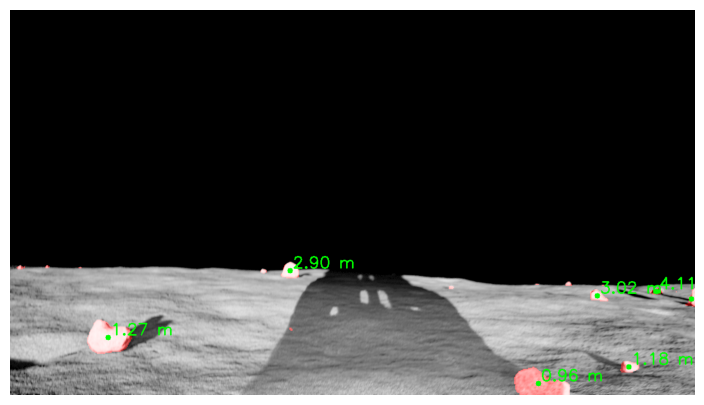

In [8]:
left_image = cv.imread(data_path / "FrontLeft" / f"{i}.png", cv.IMREAD_GRAYSCALE)
right_image = cv.imread(data_path / "FrontRight" / f"{i}.png", cv.IMREAD_GRAYSCALE)

left_seg_masks, left_seg_full_mask = segmentation.segment_rocks(left_image)
right_seg_masks, right_seg_full_mask = segmentation.segment_rocks(right_image)

results = stereo_depth_from_segmentation(
    left_seg_masks, right_seg_masks, params.STEREO_BASELINE, params.FL_X
)
left_overlay = overlay_mask(np.array(left_image), left_seg_full_mask)
left_overlay = overlay_stereo_rock_depths(left_overlay, results)
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.imshow(left_overlay)
plt.axis("off")

In [9]:
# TODO: use compute_rock_points and compute_rock_radii

In [10]:
x, _, w, _ = cv.boundingRect(results[0]["left_mask"].astype(np.uint8))
width_x = w * results[0]["depth"] / params.FL_X
print(f"Width: {width_x} m")

Width: 0.10800000000000001 m


In [11]:
rock_points_rover_frame = []
rock_data = compute_rock_radii(results)

for rock in results:
    rock_points_rover_frame.append(
        project_pixel_to_rover(rock["left_centroid"], rock["depth"], "FrontLeft", cam_config)
    )

rock_points_rover_frame = np.array(rock_points_rover_frame)
print(rock_points_rover_frame)
plot_points_rover_frame(rock_points_rover_frame, color="red")
plot_rocks_rover_frame(rock_points_rover_frame, rock_data, color="blue")


[[ 3.18334236  0.45264706 -0.27241176]
 [ 3.30184613 -1.42989796 -0.44426531]
 [ 1.54555949  0.71376923 -0.21792308]
 [ 1.46456368 -0.587736   -0.266872  ]
 [ 1.23529329 -0.28167097 -0.22226452]
 [ 4.39306834 -2.475      -0.616     ]
 [ 5.38587795 -3.45506897 -0.87451724]]


## Arc path planning


In [12]:
planner = ArcPlanner()


arcs = planner.np_candidate_arcs

In [13]:
print(rock_points_rover_frame)
test_rock_points_rover_frame = np.array([[0.5, 0.5], [0.4, -0.4], [0.2, 0.3]])

[[ 3.18334236  0.45264706 -0.27241176]
 [ 3.30184613 -1.42989796 -0.44426531]
 [ 1.54555949  0.71376923 -0.21792308]
 [ 1.46456368 -0.587736   -0.266872  ]
 [ 1.23529329 -0.28167097 -0.22226452]
 [ 4.39306834 -2.475      -0.616     ]
 [ 5.38587795 -3.45506897 -0.87451724]]


In [14]:
test_rock_data = [0.07, 0.06, 0.05]

In [15]:
# print(f"candidate arcs shape: {planner.np_candidate_arcs.shape}")
waypoint = np.array([4.25, 4.25])
# current_pose = np.eye(4)
test_rock_points_rover_frame = np.array([[]])
test_rock_data = []
control, best_arc, waypoint_local = planner.plan_arc(
    waypoint, current_pose, rock_points_rover_frame, rock_data
)
# (v,w), waypoint_local = planner.plan_arc(waypoint, current_pose, test_rock_points_rover_frame, test_rock_data)
# print(waypoint_local)
fig = plot_rocks_rover_frame(
    rock_points_rover_frame, rock_data, color="red"
)
print(f"waypoint_local{waypoint_local}")
# fig = go.Figure()
for arc in arcs:
    fig = plot_path_rover_frame(arc, fig=fig)
fig = plot_path_rover_frame(best_arc, color="green", fig=fig)

fig.show()
print(control)


waypoint_local[ 0.23245214 -8.03994011 -2.04630203  1.        ]


(0.2, -1.0)


# Arc overlay visualization


In [ ]:
from lac.utils.camera import Camera
from lac.utils.frames import get_cam_pose_rover, CAMERA_TO_OPENCV_PASSIVE
from lac.utils.plotting import plot_poses

In [ ]:
def rover_pose_to_cam_pose(rover_pose, cam_name="FrontLeft"):
    camera_pose = get_cam_pose_rover(cam_name)
    camera_pose[:3, :3] = CAMERA_TO_OPENCV_PASSIVE
    return rover_pose @ camera_pose

In [ ]:
# data_path = Path("../../output/AutoAgent/arc_planner_test")
data_path = Path("../../output/NavAgent/map1_preset4_eval")
initial_pose, lander_pose, poses, imu_data, cam_config = load_data(data_path)

In [ ]:
cam_poses = []
for pose in poses:
    cam_poses.append(rover_pose_to_cam_pose(pose))

In [ ]:
plot_poses(cam_poses[::100])

In [ ]:
cam = Camera(cam_poses[0])

# TODO: define arc points
arc_points = None

uv, depths = cam.project_world_points_to_uv(arc_points)

In [ ]:
plt.scatter(uv[:, 0], uv[:, 1], cmap="plasma")
# Set x and y limits
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.gca().invert_yaxis()
plt.show()